<a href="https://colab.research.google.com/github/poffertje/TextMining/blob/master/application/application_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Production Prototype

## Mounting the Drive (Google Colab)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -q transformers
!pip install bertopic
!pip install -U sentence-transformers
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git
!pip install -q tf-models-official==2.4.0

In [ ]:
!pip install pyyaml==5.4.0

## GPU Support (CUDA Support Required)

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

UsageError: Line magic function `%tensorflow_version` not found.


## Importing The Packages

In [ ]:
# Topic modelling with BERT necessities 
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP

# Loading models
import joblib
import os
import pickle
from six.moves import cPickle as pickle

# Features and embeddings
import scipy as scipy

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn.metrics import classification_report

# Text Preprocessing
import string
from spacy.pipeline import Sentencizer
nlp = spacy.load('en_core_web_sm')

import nltk
nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize

# Pandas
import re
import numpy as np
import pandas as pd

pd.options.display.max_rows = 15
np.set_printoptions(precision = 4, suppress=True)

# Creates a progress bar for pandas functions
from tqdm import tqdm
tqdm.pandas()

# Used for resolving paths
from pathlib import Path

# Filter out the irrelevant warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

#Sentiment Analysis Imports 
import tensorflow_hub as hub
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

## Resolving Paths

In [6]:
cur_dir = Path().resolve() # this should provide you with the folder in which this notebook is placed

In [8]:
# Use this for colab
gdrive_path_to_datasets = Path.joinpath(cur_dir, 'gdrive/Shareddrives/Minecraft/Datasets')
path_to_production = Path.joinpath(gdrive_path_to_datasets, 'production_set_1814.csv')
path_to_wordcloud_mask = Path.joinpath(gdrive_path_to_datasets, 'wordcloud.png')
print(path_to_production)
print('Does path exist? ->', Path.exists(path_to_production))

/content/gdrive/Shareddrives/Minecraft/Datasets/production_set_1814.csv
Does path exist? -> True


In [9]:
# Use this for colab
gdrive_path_to_models = Path.joinpath(cur_dir, 'gdrive/Shareddrives/Minecraft/Our_Models')
print(gdrive_path_to_models)
print('Does path exist? ->', Path.exists(gdrive_path_to_models))

/content/gdrive/Shareddrives/Minecraft/Our_Models
Does path exist? -> True


## Importing The Production Data

In [10]:
#encoding for the fake classifier
encode_label = {-1 : 0, 1 : 1}

In [12]:
# Single restaurant data
production_test = pd.read_csv(path_to_production)
production_test['label'] = production_test['label'].map(encode_label)

In [13]:
# add additional columns used for feature space
def adding_columns(data):
  data["review_length"] = data['review'].str.split().str.len()
  nr_rows = data.groupby('userID').size().astype(float).reset_index(name="nr of rows")
  extreme_count = (data.groupby('userID')['rating'].apply(lambda x: (x == (1.0 or 5.0) ).sum())).reset_index(name="extreme_count_ratio")
  extreme_count["extreme_count_ratio"] = extreme_count["extreme_count_ratio"].astype(float).div(nr_rows["nr of rows"].values,axis=0)
  data = pd.merge(data, extreme_count, how='left', on = 'userID')
  return data

In [14]:
production_test = adding_columns(production_test)
original_data = production_test.copy(deep = True) # keep a copy of processed dataeset

## **Fake Reviews Classifier**

In [15]:
# Relevant Paths
path_to_fake_classifier = Path.joinpath(gdrive_path_to_models, 'LogisticRegression')
path_to_fake_classifier_model = Path.joinpath(path_to_fake_classifier, 'finalized_model.sav')
path_to_fake_classifier_pkl = Path.joinpath(path_to_fake_classifier, 'vectorizer.pickle')

In [16]:
# Loading the model
model = joblib.load(path_to_fake_classifier_model)

In [17]:
#create a stemmer
stemmer = SnowballStemmer("english")

# Define our own tokenizing function that we will pass into the TFIDFVectorizer. We will also stem the words here.
def tokens(x):
    x = x.split()
    stems = []
    [stems.append(stemmer.stem(word)) for word in x]
    return stems

# Helper method that removes punctuation from the string
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', string.punctuation))

# Method that allows a pandas dataframe to be converted into the right format (feature space) to be taken as input for the fake review classifier model
def features_conversion(data):
  os.chdir('/content/gdrive/Shareddrives/Minecraft/Our_Models/LogisticRegression/')
  # drop NaN rows
  data = data.dropna()
  data.loc[:, 'review'] = data['review'].str.lower()
  data['review']=data['review'].apply( lambda x: remove_punctuation(x))
  vectorizer = joblib.load("vectorizer.pickle")
  features_created = vectorizer.transform(data['review'])
  length = np.array(list(data.review_length)).reshape(features_created.shape[0], 1)
  features_created = scipy.sparse.hstack((features_created,scipy.sparse.csr_matrix(length)))
  xtreme_ratio = np.array(list(data.extreme_count_ratio)).reshape(features_created.shape[0],1)
  features_created = scipy.sparse.hstack((features_created,scipy.sparse.csr_matrix(xtreme_ratio)))
  features_created = scipy.sparse.csr_matrix(features_created)
  return features_created

In [19]:
production_test_predictions = model.predict(features_conversion(production_test))

In [21]:
# Evaluating the step
true_labels = production_test['label']
print(classification_report(true_labels, production_test_predictions))

              precision    recall  f1-score   support

           0       0.30      0.62      0.40       348
           1       0.91      0.72      0.80      1807

    accuracy                           0.70      2155
   macro avg       0.60      0.67      0.60      2155
weighted avg       0.81      0.70      0.74      2155



### Updating the Production Set

In [22]:
production_test['fake prediction'] = production_test_predictions

In [23]:
production_test = production_test[production_test['fake prediction'] == 1]

In [24]:
production_test = production_test.reset_index(drop=True)

# **Sentiment Analysis**

In [26]:
path_to_sentiment_weights = Path.joinpath(gdrive_path_to_datasets, '100k-2e5-16-02-8April_sentiment_sample_25_75_mixed_weights')

Defining Constants, Parameters and Bert Model

In [27]:
threshold = 0.6
label_list = [0, 1] # Label categories
max_seq_length = 128 # maximum length of (token) input sequences

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)



In [28]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)
  
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [29]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  # py_func doesn't set the shape of the returned tensors.
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

Creation of Custom Layer

In [30]:
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.3)(pooled_output)
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop)

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  return model

Prediction Function

In [31]:
def predict_labels(sample_data,model):
  test_data = tf.data.Dataset.from_tensor_slices((sample_data, [0]*len(sample_data)))
  test_data = (test_data.map(to_feature_map).batch(1))
  preds = model.predict(test_data)
  return preds

In [32]:
def convert_from_threshold(sample_data, model, threshold):
  pred_probs = predict_labels(sample_data,model)
  predicted = [1 if pred > threshold else 0 for pred in pred_probs]
  return predicted

Loading the Trained Model

In [ ]:
loaded_model = create_model()
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
loaded_model.load_weights(path_to_sentiment_weights)

In [35]:
production_test_sentiments = convert_from_threshold(production_test['review'], loaded_model, threshold)

In [36]:
original_data_sentiments = convert_from_threshold(original_data['review'], loaded_model, threshold)

In [37]:
true_labels = production_test['sentiment label']
print(classification_report(true_labels, production_test_sentiments))

              precision    recall  f1-score   support

           0       0.68      0.69      0.68       391
           1       0.88      0.88      0.88      1044

    accuracy                           0.83      1435
   macro avg       0.78      0.78      0.78      1435
weighted avg       0.83      0.83      0.83      1435



### Updating the Production Set

In [38]:
production_test['sentiment prediction'] = production_test_sentiments

### Updating Orginal Dataset


In [39]:
original_data['sentiment prediction'] = original_data_sentiments

### Splitting Reviews Into Sentences

In [40]:
# Construction via add_pipe
sentencizer = nlp.create_pipe("sentencizer")

# Construction from class
sentencizer = Sentencizer()

In [41]:
sentiment_labels = []
review_sentences = []

for i in range(len(production_test['review'])):
  doc = nlp(production_test['review'][i])
  for x in doc.sents:
    review_sentences.append(str(x))
    sentiment_labels.append(production_test['sentiment prediction'][i])

In [42]:
od_sentiment_labels = []
od_review_sentences = []

for i in range(len(original_data['review'])):
  od_doc = nlp(original_data['review'][i])
  for x in od_doc.sents:
    od_review_sentences.append(str(x))
    od_sentiment_labels.append(original_data['sentiment prediction'][i])

In [43]:
data = {'review': review_sentences, 'sentiment_labels': sentiment_labels}  
splitted_production_test  = pd.DataFrame(data)

In [44]:
od_data = {'review': od_review_sentences, 'sentiment_labels': od_sentiment_labels}  
splitted_original_data  = pd.DataFrame(od_data)

# **Topic Modelling**

In [45]:
path_to_bertopic = Path.joinpath(gdrive_path_to_models, 'BERTopic/first_model_20_new')

In [46]:
prediction_model = BERTopic.load(path_to_bertopic)

In [47]:
labels = []

for review in splitted_production_test['review']:
    add = prediction_model.find_topics(review, top_n=5) 
    labels.append(add[0][0])

In [48]:
od_labels = []

for review in splitted_original_data['review']:
    od_add = prediction_model.find_topics(review, top_n=5) 
    od_labels.append(od_add[0][0])

In [49]:
splitted_production_test['topic prediction'] = labels

In [50]:
splitted_original_data['topic prediction'] = od_labels

In [51]:
usable_bins = [-2, -1, 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19]

In [52]:
labels_map = ["Other", "Food", "Food", "Food", "Food", "Service", "Food", "Food", "Food", "Food", "Food", "Food", "Food", "Food", "Food", "Food", "Drinks", "Food", "Food", "Food", "Food"]

In [53]:
x = splitted_production_test['topic prediction']
od_x = splitted_original_data['topic prediction']

In [55]:
splitted_production_test["map"] = pd.cut(
    x=x,
    bins=usable_bins,
    labels=labels_map,
    ordered=False
)

splitted_original_data["map"] = pd.cut(
    x=od_x,
    bins=usable_bins,
    labels=labels_map,
    ordered=False
)


## Visualization


Topic Frequency before & after filtering out fake reviews

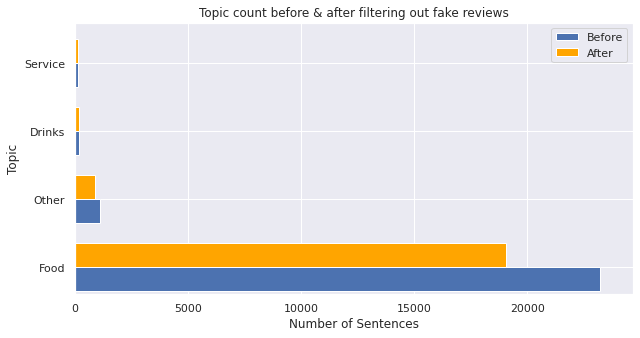

In [56]:
# graph to show how frequent each topic is before and after filtering out fake reviews
def topics_graph(before, after): 
  fig, ax = plt.subplots()
  ax = before['map'].value_counts().plot(kind = 'barh', width = 0.35, position= 1, figsize = (10, 5))
  ax = after['map'].value_counts().plot(kind = 'barh',color = "orange", position=0, width = 0.35 )
  
  ax.set_ylim(-.4,)
  ax.set_xlim(0,len(before))
  ax.set_title("Topic count before & after filtering out fake reviews") 
  ax.legend(["Before", "After"])
  ax.set_ylabel("Topic")
  ax.set_xlabel("Number of Sentences")
  plt.savefig('topic_freq.png')
  return (plt.show())
topics_graph(splitted_original_data,splitted_production_test) 

Topic Sentiment Frequency before & after filtering out fake reviews

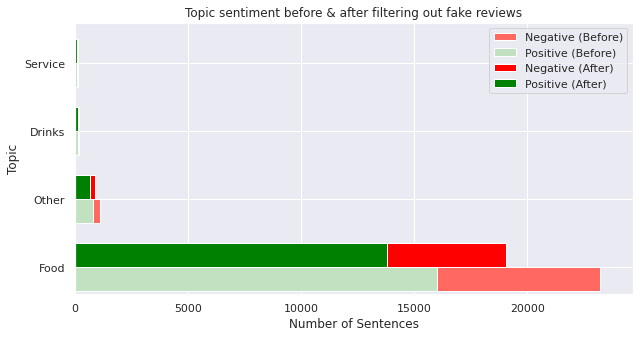

In [57]:
# graph to show how frequent each topic sentiment is before and after filtering out fake reviews

def sent_graph(before, after): 
  
  pos_sent = before[before['sentiment_labels'] == 1] # positive sentiment
  pos_sent_after = after[after['sentiment_labels'] == 1] # positive sentiment after filtering out review
  fig, ax = plt.subplots()
  
  ax = before['map'].value_counts().plot(kind = 'barh', color = "#FF6961", width = 0.35, position= 1, figsize = (10, 5) ,label = "Negative (Before)")
  ax = pos_sent['map'].value_counts().plot(kind = 'barh', color = "#C1E1C1", width = 0.35, position= 1, label = "Positive (Before)")
  ax = after['map'].value_counts().plot(kind = 'barh', color = "red", width = 0.35, position= 0, label = "Negative (After)" )
  ax = pos_sent_after['map'].value_counts().plot(kind = 'barh', color = "green", width = 0.35, position= 0, label = "Positive (After)")
  ax.set_ylim(-.4,)
  ax.set_xlim(0,len(before))
  ax.set_title("Topic sentiment before & after filtering out fake reviews")
  ax.legend()
  ax.set_ylabel("Topic")
  ax.set_xlabel("Number of Sentences")
  plt.savefig('topic_senti_freq.png')
  return (plt.show())
sent_graph(splitted_original_data, splitted_production_test)

Proportion of fake vs real reviews for the restaurant


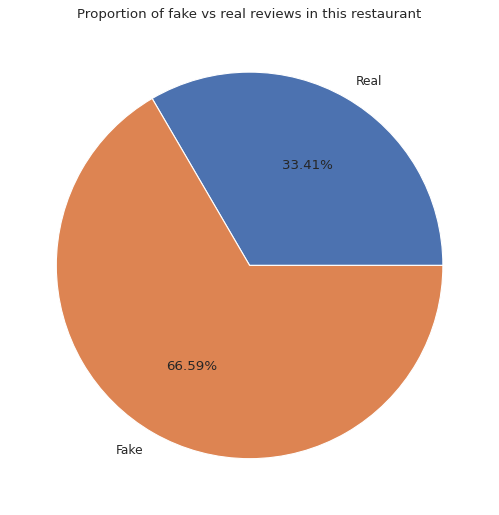

In [58]:
#Pie chart that shows proportion of fake and real reviews for a restaurant
from matplotlib.pyplot import figure

figure(figsize=(8, 8), dpi=80)
mylabels = ["Real", "Fake"]
prop_fake = (production_test_predictions == 1).sum()/len(production_test_predictions) * 100
prop_real = 100 - prop_fake


y = np.array([prop_real, prop_fake])
plt.pie(y, labels = mylabels, autopct='%1.2f%%')
plt.title("Proportion of fake vs real reviews in this restaurant")
plt.savefig('piechart.png')
plt.show() 


Word Cloud for most occuring words in real reviews

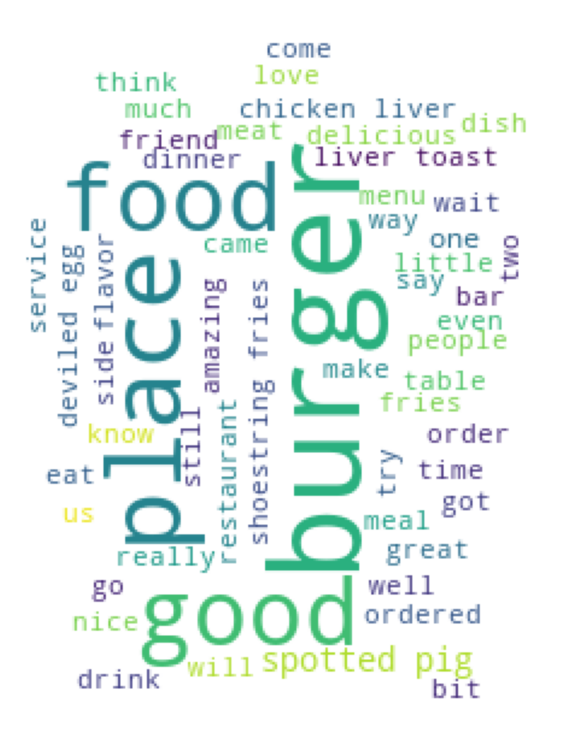

In [59]:
#Word Cloud for most frequent words in the restaurant reviews after filtering out fake reviews
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd
import  numpy as np
from PIL import Image
import requests
comment_words = '' 
stopwords = set(STOPWORDS)

for val in splitted_production_test.review: 
      
    val = str(val) 
  
    tokens = val.split() 
      
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
pic = np.array(Image.open(requests.get('http://www.clker.com/cliparts/4/8/a/6/1194984081402633375french_fries_juliane_kr_r.svg.med.png',stream=True).raw))

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, mask = pic, 
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.savefig('wordcloud.png')
plt.show()
